<a href="https://colab.research.google.com/github/GilgameshxZero/adversarial-ntks/blob/master/notebooks/tony_svm_smaller_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://www.github.com/google/neural-tangents
# !pip install https://github.com/Xtra-Computing/thundersvm/releases/download/v0.3.4/thundersvm_cuda10.1-0.3.4-cp36-cp36m-linux_x86_64.whl

In [ ]:
import functools
import operator

import matplotlib.pyplot as plt
import numpy as np

import sklearn
from sklearn import svm
# from thundersvm import SVC

import tensorflow as tf
import tensorflow_datasets as tfds

import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

import neural_tangents as nt
from neural_tangents import stax as ntstax

tf.random.set_seed(42)

[4 1 0 7 8 1 2 7 1 6]


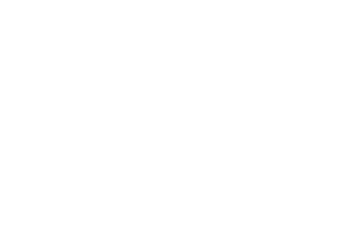

[2 0 4 8 7 6 0 6 3 1]


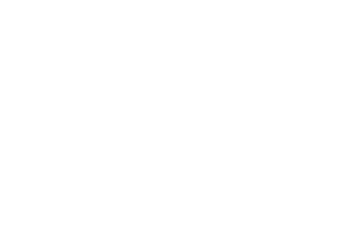

[7 8 4 4 6 5 2 9 6 6]


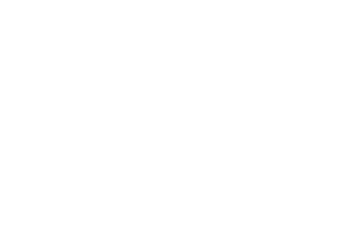

[7 0 6 9 5 1 7 0 3 2]


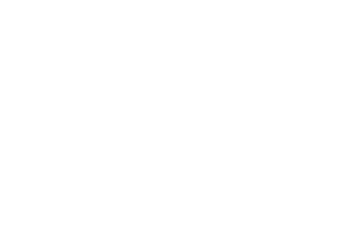

In [ ]:
def downsample_imgs(imgs, image_width):
    return tf.image.resize(
        tf.convert_to_tensor(imgs),
        size=[image_width, image_width],
        method=tf.image.ResizeMethod.BILINEAR,
        preserve_aspect_ratio=True,
        antialias=False,
    ).numpy()

def get_np_data(
    name, # "mnist" or "cifar10"
    split,
    binary_labels=False,
    flatten=True,
    image_width=None,
):
    """
    name: e.g. "mnist", "cifar10". See
          https://www.tensorflow.org/datasets/catalog/overview for more details.
    split: See https://www.tensorflow.org/datasets/splits
    """

    xs, ys = operator.itemgetter('image', 'label')(
        tfds.as_numpy(
            tfds.load(
                name=name,
                split=split,
                batch_size=-1,
                data_dir="./data",
            )
        )
    )

    xs = xs.astype(np.float64)
    xs /= 255.0 # normalize

    if binary_labels:
        n_classes = ys.max() + 1
        ys = (ys >= (n_classes // 2)).astype(np.int)

    if image_width is not None:
        xs = downsample_imgs(xs, image_width)

    if flatten:
        xs = xs.reshape((len(xs), -1))

    return xs, ys

MNIST_TRAIN = get_np_data(name="mnist", split="train[:2000]")#, image_width=7)
MNIST_TEST = get_np_data(name="mnist", split="test[:2000]")#, image_width=7)

for data in [MNIST_TRAIN, MNIST_TEST]:
    xs, ys = data
    print(ys[:10])
    for i, x in enumerate(xs[:10]):
        plt.subplot(1, 10, i + 1)
        #plt.imshow(x.reshape(7, 7))
        plt.axis('off')
    plt.show();

CIFAR_TRAIN = get_np_data(name="cifar10", split="train[:2000]")#, image_width=8)
CIFAR_TEST = get_np_data(name="cifar10", split="test[:2000]")#, image_width=8)

for data in [CIFAR_TRAIN, CIFAR_TEST]:
    xs, ys = data
    print(ys[:10])
    for i, x in enumerate(xs[:10]):
        plt.subplot(1, 10, i + 1)
        #plt.imshow(x.reshape(8, 8, 3))
        plt.axis('off')
    plt.show();

In [ ]:
def clf_acc(clf, test_data):
    test_xs, test_ys = test_data
    return np.mean(
        clf.predict(test_xs) == test_ys
    )

# Linear kernel

In [ ]:
%%time
for C in [1, 10, 100, 1000, 10000]:
    clf = svm.SVC(kernel="linear", C=C)
    clf.fit(*MNIST_TRAIN)
    print(f"C={C:7} linear mnist test acc: {clf_acc(clf, MNIST_TEST)}")

C=      1 linear mnist test acc: 0.772
C=     10 linear mnist test acc: 0.78
C=    100 linear mnist test acc: 0.7885
C=   1000 linear mnist test acc: 0.7905
C=  10000 linear mnist test acc: 0.7915
CPU times: user 1min 35s, sys: 30.8 ms, total: 1min 35s
Wall time: 1min 35s


In [ ]:
%%time
for C in [0.01, 0.1, 1, 10, 100]:
    clf = svm.SVC(kernel="linear", C=C)
    clf.fit(*CIFAR_TRAIN)
    print(f"C={C:5} linear cifar test acc: {clf_acc(clf, CIFAR_TEST)}")

C= 0.01 linear cifar test acc: 0.563
C=  0.1 linear cifar test acc: 0.5755
C=    1 linear cifar test acc: 0.5735
C=   10 linear cifar test acc: 0.552
C=  100 linear cifar test acc: 0.5565
CPU times: user 40 s, sys: 20.9 ms, total: 40.1 s
Wall time: 40.1 s


# Polynomial kernel

In [ ]:
%%time
for C in [0.1, 1, 10, 100]:
    clf = svm.SVC(kernel="poly", C=C, degree=3)
    clf.fit(*MNIST_TRAIN)
    print(f"C={C:5} poly mnist test acc: {clf_acc(clf, MNIST_TEST)}")

C=  0.1 poly mnist test acc: 0.846
C=    1 poly mnist test acc: 0.887
C=   10 poly mnist test acc: 0.8935
C=  100 poly mnist test acc: 0.8765
CPU times: user 919 ms, sys: 976 µs, total: 920 ms
Wall time: 919 ms
Parser   : 147 ms


In [ ]:
%%time
for C in [0.01, 0.1, 1, 10, 100]:
    clf = svm.SVC(kernel="poly", C=C, degree=3)
    clf.fit(*CIFAR_TRAIN)
    print(f"C={C:5} poly cifar test acc: {clf_acc(clf, CIFAR_TEST)}")

C= 0.01 poly cifar test acc: 0.599
C=  0.1 poly cifar test acc: 0.604
C=    1 poly cifar test acc: 0.605
C=   10 poly cifar test acc: 0.589
C=  100 poly cifar test acc: 0.5955
CPU times: user 14.6 s, sys: 11 ms, total: 14.7 s
Wall time: 14.7 s


# RBF kernel

In [ ]:
%%time
for C in [1, 10, 100, 1000, 10000]:
    clf = svm.SVC(kernel="rbf", C=C, gamma="auto")
    clf.fit(*MNIST_TRAIN)
    print(f"C={C:5} rbf mnist test acc: {clf_acc(clf, MNIST_TEST)}")

C=    1 rbf mnist test acc: 0.8905
C=   10 rbf mnist test acc: 0.9235
C=  100 rbf mnist test acc: 0.9195
C= 1000 rbf mnist test acc: 0.92
C=10000 rbf mnist test acc: 0.92
CPU times: user 22.9 s, sys: 6.05 ms, total: 22.9 s
Wall time: 22.9 s


In [ ]:
%%time
for C in [1, 10, 100, 1000, 10000]:
    clf = svm.SVC(kernel="rbf", C=C, gamma="auto")
    clf.fit(*CIFAR_TRAIN)
    print(f"C={C:5} rbf cifar test acc: {clf_acc(clf, CIFAR_TEST)}")

C=    1 rbf cifar test acc: 0.3285
C=   10 rbf cifar test acc: 0.376
C=  100 rbf cifar test acc: 0.377
C= 1000 rbf cifar test acc: 0.3675
C=10000 rbf cifar test acc: 0.367
CPU times: user 3min 39s, sys: 76.4 ms, total: 3min 39s
Wall time: 3min 39s


# Laplace kernel

In [ ]:
%%time
def laplace_kfn(A, B):
    return sklearn.metrics.pairwise.laplacian_kernel(A, B, 0.1)

for C in [0.01, 0.1, 1, 10, 100, 1000]:
    clf = svm.SVC(kernel=laplace_kfn, C=C)
    clf.fit(*MNIST_TRAIN)
    print(f"C={C:5} laplace mnist test acc: {clf_acc(clf, MNIST_TEST)}")

C= 0.01 laplace mnist test acc: 0.5115
C=  0.1 laplace mnist test acc: 0.7765
C=    1 laplace mnist test acc: 0.8725
C=   10 laplace mnist test acc: 0.908
C=  100 laplace mnist test acc: 0.901
C= 1000 laplace mnist test acc: 0.901
CPU times: user 2.44 s, sys: 4 ms, total: 2.45 s
Wall time: 2.45 s


In [ ]:
%%time
def laplace_kfn(A, B):
    return sklearn.metrics.pairwise.laplacian_kernel(A, B, 0.05)

for C in [0.01, 0.1, 1, 10, 100, 1000]:
    clf = svm.SVC(kernel=laplace_kfn, C=C)
    clf.fit(*CIFAR_TRAIN)
    print(f"C={C:5} laplace cifar test acc: {clf_acc(clf, CIFAR_TEST)}")

C= 0.01 laplace cifar test acc: 0.495
C=  0.1 laplace cifar test acc: 0.568
C=    1 laplace cifar test acc: 0.612
C=   10 laplace cifar test acc: 0.6165
C=  100 laplace cifar test acc: 0.6165
C= 1000 laplace cifar test acc: 0.6165
CPU times: user 7.03 s, sys: 9.97 ms, total: 7.04 s
Wall time: 7.03 s


# FC NTK

In [ ]:
_, _, fc_ntk = ntstax.serial(
    ntstax.Dense(1, W_std=1, b_std=1), ntstax.Relu(),
    ntstax.Dense(1, W_std=1, b_std=1), ntstax.Relu(),
    ntstax.Dense(1, W_std=1, b_std=1), ntstax.Relu(),
    ntstax.Dense(1, W_std=1, b_std=1)
)

@jax.jit
def fc_kfn(A, B):
    return fc_ntk(A, B, "ntk")

In [ ]:
%%time
for C in [0.01, 0.1, 1, 10, 100, 1000]:
    clf = svm.SVC(kernel=fc_kfn, C=C)
    clf.fit(*MNIST_TRAIN)
    print(f"C={C:5} fc-ntk mnist test acc: {clf_acc(clf, MNIST_TEST)}")

C= 0.01 fc-ntk mnist test acc: 0.5115
C=  0.1 fc-ntk mnist test acc: 0.6985
C=    1 fc-ntk mnist test acc: 0.796
C=   10 fc-ntk mnist test acc: 0.891
C=  100 fc-ntk mnist test acc: 0.9065
C= 1000 fc-ntk mnist test acc: 0.9065
CPU times: user 1.53 s, sys: 558 ms, total: 2.09 s
Wall time: 2.38 s


In [ ]:
%%time
for C in [0.01, 0.1, 1, 10, 100, 1000]:
    clf = svm.SVC(kernel=fc_kfn, C=C)
    clf.fit(*CIFAR_TRAIN)
    print(f"C={C:5} fc-ntk mnist test acc: {clf_acc(clf, CIFAR_TEST)}")

C= 0.01 fc-ntk mnist test acc: 0.495
C=  0.1 fc-ntk mnist test acc: 0.495
C=    1 fc-ntk mnist test acc: 0.58
C=   10 fc-ntk mnist test acc: 0.602
C=  100 fc-ntk mnist test acc: 0.616
C= 1000 fc-ntk mnist test acc: 0.616
CPU times: user 1.38 s, sys: 200 ms, total: 1.58 s
Wall time: 1.71 s


# CNN NTK

In [ ]:
def get_batched_cnn_kfn(base_kfn, image_width, num_channels, batch_size):
    def batched_cnn_kfn(A, B):
        assert len(A) % batch_size == len(B) % batch_size == 0

        A = A.reshape((-1, image_width, image_width, num_channels))
        B = B.reshape((-1, image_width, image_width, num_channels))
        res = np.zeros((len(A), len(B)))
        for i in range(len(A) // batch_size):
            alo, ahi = batch_size * i, batch_size * (i + 1)
            for j in range(len(B) // batch_size):
                blo, bhi = batch_size * j, batch_size * (j + 1)
                res[alo:ahi, blo:bhi] = (
                    base_kfn(A[alo:ahi], B[blo:bhi])
                )

        return res

    return batched_cnn_kfn

### Flatten

In [ ]:
_, _, cnn_flat_ntk = ntstax.serial(
    ntstax.Conv(1, (3, 3), W_std=1, b_std=1), ntstax.Relu(),
    ntstax.Conv(1, (3, 3), W_std=1, b_std=1), ntstax.Relu(),
    ntstax.Conv(1, (3, 3), W_std=1, b_std=1), ntstax.Relu(),
    ntstax.Flatten(),
    ntstax.Dense(1, W_std=1, b_std=1)
)

@jax.jit
def cnn_flat_base_kfn(A, B):
    return cnn_flat_ntk(A, B, "ntk")

In [ ]:
%%time
for C in [0.01, 0.1, 1, 10, 100, 1000]:
    clf = svm.SVC(
        C=C,
        kernel=get_batched_cnn_kfn(
            base_kfn=cnn_flat_base_kfn,
            image_width=7,
            num_channels=1,
            batch_size=100
        )
    )
    clf.fit(*MNIST_TRAIN)
    print(f"C={C:5} cnn-flat-ntk mnist test acc: {clf_acc(clf, MNIST_TEST)}")

C= 0.01 cnn-flat-ntk mnist test acc: 0.5115
C=  0.1 cnn-flat-ntk mnist test acc: 0.7365
C=    1 cnn-flat-ntk mnist test acc: 0.8145
C=   10 cnn-flat-ntk mnist test acc: 0.8895
C=  100 cnn-flat-ntk mnist test acc: 0.9
C= 1000 cnn-flat-ntk mnist test acc: 0.9
CPU times: user 8.02 s, sys: 3.56 s, total: 11.6 s
Wall time: 10.8 s


In [ ]:
%%time
for C in [0.01, 0.1, 1, 10, 100, 1000]:
    clf = svm.SVC(
        C=C,
        kernel=get_batched_cnn_kfn(
            base_kfn=cnn_flat_base_kfn,
            image_width=8,
            num_channels=3,
            batch_size=100
        )
    )
    clf.fit(*CIFAR_TRAIN)
    print(f"C={C:5} cnn-flat-ntk cifar test acc: {clf_acc(clf, CIFAR_TEST)}")

C= 0.01 cnn-flat-ntk cifar test acc: 0.495
C=  0.1 cnn-flat-ntk cifar test acc: 0.495
C=    1 cnn-flat-ntk cifar test acc: 0.587
C=   10 cnn-flat-ntk cifar test acc: 0.6035
C=  100 cnn-flat-ntk cifar test acc: 0.61
C= 1000 cnn-flat-ntk cifar test acc: 0.61
CPU times: user 12.4 s, sys: 5.86 s, total: 18.2 s
Wall time: 17.2 s


### Global average pooling

In [ ]:
_, _, cnn_gap_ntk = ntstax.serial(
    ntstax.Conv(1, (3, 3), W_std=1, b_std=1), ntstax.Relu(),
    ntstax.Conv(1, (3, 3), W_std=1, b_std=1), ntstax.Relu(),
    ntstax.Conv(1, (3, 3), W_std=1, b_std=1), ntstax.Relu(),
    ntstax.GlobalAvgPool(),
    ntstax.Dense(1, W_std=1, b_std=1)
)

@jax.jit
def cnn_gap_base_kfn(A, B):
    return cnn_gap_ntk(A, B, "ntk")

In [ ]:
%%time
for C in [1, 10, 100, 1000, 10000, 100000]:
    clf = svm.SVC(
        C=C,
        kernel=get_batched_cnn_kfn(
            base_kfn=cnn_gap_base_kfn,
            image_width=7,
            num_channels=1,
            batch_size=100
        )
    )
    clf.fit(*MNIST_TRAIN)
    print(f"C={C:8} cnn-gap-ntk mnist test acc: {clf_acc(clf, MNIST_TEST)}")

C=       1 cnn-gap-ntk mnist test acc: 0.8145
C=      10 cnn-gap-ntk mnist test acc: 0.8895
C=     100 cnn-gap-ntk mnist test acc: 0.9
C=    1000 cnn-gap-ntk mnist test acc: 0.9
C=   10000 cnn-gap-ntk mnist test acc: 0.9
C=  100000 cnn-gap-ntk mnist test acc: 0.9
CPU times: user 55 s, sys: 31.7 s, total: 1min 26s
Wall time: 1min 25s


In [ ]:
%%time
for C in [1, 10, 100, 1000, 10000, 100000]:
    clf = svm.SVC(
        C=C,
        kernel=get_batched_cnn_kfn(
            base_kfn=cnn_gap_base_kfn,
            image_width=8,
            num_channels=3,
            batch_size=100
        )
    )
    clf.fit(*CIFAR_TRAIN)
    print(f"C={C:8} cnn-gap-ntk cifar test acc: {clf_acc(clf, CIFAR_TEST)}")

C=       1 cnn-gap-ntk cifar test acc: 0.578
C=      10 cnn-gap-ntk cifar test acc: 0.607
C=     100 cnn-gap-ntk cifar test acc: 0.624
C=    1000 cnn-gap-ntk cifar test acc: 0.627
C=   10000 cnn-gap-ntk cifar test acc: 0.627
C=  100000 cnn-gap-ntk cifar test acc: 0.627
CPU times: user 2min 4s, sys: 1min 17s, total: 3min 21s
Wall time: 3min 20s
